In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [7]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(24492, 7546)

In [8]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [9]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [10]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2022-03-18 21:53:59,622] A new study created in memory with name: no-name-369c05b7-10ec-4ae1-8527-1432912c46a1
[I 2022-03-18 21:54:03,493] Trial 0 finished with value: 0.0011021815007552505 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.0011021815007552505.
[I 2022-03-18 21:54:05,876] Trial 1 finished with value: 0.005602755583822727 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.005602755583822727.
[I 2022-03-18 21:54:08,371] Trial 2 finished with value: 0.0016532721929252148 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.0001, 'max_sampled': 100, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.005602755583822727.
[I 2022-03-18 21:54:10,826] Trial 3 finished with value: 0.000711825501639396 and

In [12]:
best_params

{'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 20,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [13]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.005510907154530287 +/- 0.0007461144971000506
1:	0.005809414200484753 +/- 0.0007669074378439786
2:	0.005809414200484753 +/- 0.0007669074378439786
3:	0.005832376889884472 +/- 0.0007707069024563933
4:	0.006039035506546497 +/- 0.0007810622691270319
5:	0.006337542552500963 +/- 0.0008007747855279131
6:	0.006796785164624453 +/- 0.0008346841773747107
7:	0.007485648151487112 +/- 0.0008861512669543904
8:	0.008266360498964787 +/- 0.000924906912426359
9:	0.00943742785602808 +/- 0.0010006322669101541
10:	0.010355913080275059 +/- 0.001055882280043438
11:	0.011504017747938633 +/- 0.001105624839769262
12:	0.012284730561077595 +/- 0.0011469188462528213
13:	0.01315729133784771 +/- 0.001182004589519514
14:	0.01400688849389553 +/- 0.0012265436308783648
15:	0.014695752412080765 +/- 0.0012666769971818358
16:	0.015591274946928024 +/- 0.0013007571104583643
17:	0.016119403764605522 +/- 0.0013160143839487006
18:	0.01703788712620735 +/- 0.0013409767779382384
19:	0.01800229586660862 +/- 0.0013658878337920695

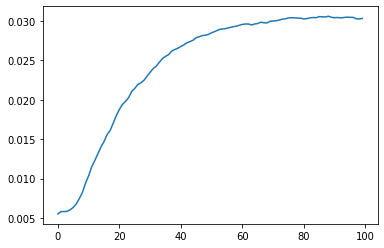

In [14]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [22]:
biases, embeddings = model.get_item_representations()

In [23]:
model.item_biases *= 0.0

In [24]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [25]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [26]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [27]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [28]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6755/6755 [00:03<00:00, 1858.38it/s]
